In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf

%matplotlib inline

2023-02-02 11:17:16.644495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
from tensorflow.keras.datasets import mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
single_image = x_train[0]

5


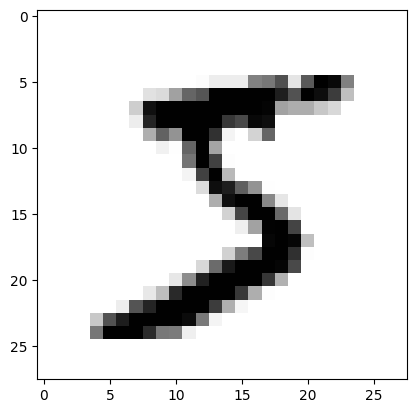

In [7]:
print(y_train[0])
plt.imshow(single_image, cmap='binary')

In [8]:
from tensorflow.keras.utils import to_categorical

In [9]:
y_train_cat = to_categorical(y_train)

In [10]:
y_train_cat.shape

(60000, 10)

In [11]:
y_train_cat[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

The best way to do this is to actually use a transformer/encoder that is fit to training (and eventually, all) data that will be used on training the production model. It is fine to do this with the labels as we won't have access to them in running predictions anyway, but if we want to use one-hot encoding on features, using the to_categorical function will not suffice. The reason is this: if you use the to_categorical operation, it can only operate on what it sees. Hence, if it is used in preprocessing for smaller batches of data that will be fed into the model for prediction, the smaller batches may not be contain all of the unique values that were present in the training data.


In [12]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
cat_transformer = OneHotEncoder(sparse_output=False)

In [14]:
cat_transformer.fit(y_train.reshape(-1,1))

OneHotEncoder(sparse_output=False)

In [15]:
y_train_cat = cat_transformer.transform(y_train.reshape(-1,1))
y_train_cat_tf = to_categorical(y_train)

In [16]:
for i in range(10):
    print('Using tf.keras.utils.to_categorial:')
    print(y_train[i], '->', y_train_cat_tf[i])
    print('Using a fit OneHotEncoder:')
    print(y_train[i], '->', y_train_cat[i])
    print('*'*40)

Using tf.keras.utils.to_categorial:
5 -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Using a fit OneHotEncoder:
5 -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
****************************************
Using tf.keras.utils.to_categorial:
0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Using a fit OneHotEncoder:
0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
****************************************
Using tf.keras.utils.to_categorial:
4 -> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Using a fit OneHotEncoder:
4 -> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
****************************************
Using tf.keras.utils.to_categorial:
1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Using a fit OneHotEncoder:
1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
****************************************
Using tf.keras.utils.to_categorial:
9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Using a fit OneHotEncoder:
9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
****************************************
Using tf.keras.utils.to_categorial:
2 -> [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Using a fit OneHotEncoder:
2 -> [0. 0

In [17]:
y_test_cat = cat_transformer.transform(y_test.reshape(-1,1))

We know that 255 is the maximum value of any entry, so instead of using a MinMaxScaler, we can just divide by 255

In [18]:
x_train = x_train/255
x_test = x_test/255

In [19]:
single_image = x_train[0]

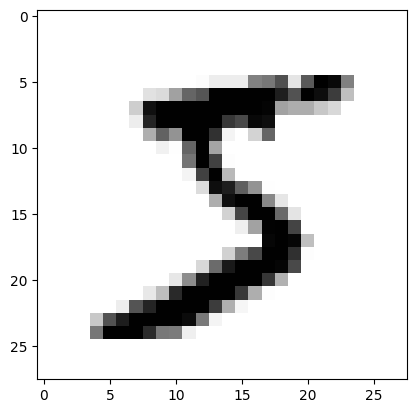

In [20]:
plt.imshow(single_image, cmap='binary')

In [21]:
# batch size, width, height, color_channels
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [22]:
x_train.shape

(60000, 28, 28, 1)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [24]:
model = Sequential()

model.add(
    Conv2D(
        input_shape=(x_train.shape[1], x_train.shape[2], 1), # input_shape is fixed by actual data
        filters=2**5, kernel_size=(4,4), strides=(1,1), padding='valid', activation='relu' # hyperparameters 
    )
)
model.add(
    MaxPool2D(
        pool_size=(4,4) # hyperparameters 
    )
) 

model.add(Flatten()) # must be here 

model.add(
    Dense(
        units=2**7, activation='relu' # hyperparameters 
    )
)

# OUTPUT LAYER
# Use softmax activation for multiclass classification
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2023-02-02 11:17:30.539221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 32)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 128)               147584    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 149,418
Trainable params: 149,418
Non-trainable params: 0
__________________________________________________

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

print(datetime.now().strftime("%Y-%m-%d--%H%M"))
log_directory = f'cnn_logs/fit/{datetime.now().strftime("%Y%m%d-%H%M%S")}'
print(log_directory)

2023-02-02--1117
cnn_logs/fit/20230202-111730


In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [28]:
board = TensorBoard(log_dir=log_directory,histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1)

2023-02-02 11:17:30.715157: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-02 11:17:30.715176: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-02-02 11:17:30.717243: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.


In [29]:
model.fit(x_train, y_train_cat, epochs=20, validation_data=(x_test, y_test_cat), callbacks=[early_stop, board])

Epoch 1/20
  30/1875 [..............................] - ETA: 9s - loss: 1.6449 - accuracy: 0.5427 

2023-02-02 11:17:31.989796: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2023-02-02 11:17:31.989806: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2023-02-02 11:17:32.000313: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2023-02-02 11:17:32.004944: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2023-02-02 11:17:32.009976: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: cnn_logs/fit/20230202-111730/plugins/profile/2023_02_02_11_17_32/HOBNJML-C40PLVD.xplane.pb


1875/1875 [==============================] - 10s 5ms/step - loss: 0.1694 - accuracy: 0.9493 - val_loss: 0.0588 - val_accuracy: 0.9812
Epoch 2/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0593 - accuracy: 0.9822 - val_loss: 0.0473 - val_accuracy: 0.9846
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0418 - accuracy: 0.9871 - val_loss: 0.0428 - val_accuracy: 0.9859
Epoch 4/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0315 - accuracy: 0.9904 - val_loss: 0.0346 - val_accuracy: 0.9876
Epoch 5/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0242 - accuracy: 0.9921 - val_loss: 0.0330 - val_accuracy: 0.9901
Epoch 6/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0193 - accuracy: 0.9942 - val_loss: 0.0362 - val_accuracy: 0.9886
Epoch 7/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0154 - accuracy: 0.9951 - val_loss: 0.0426 - val_accuracy: 0.988

In [30]:
metrics = pd.DataFrame(model.history.history)

<AxesSubplot: >

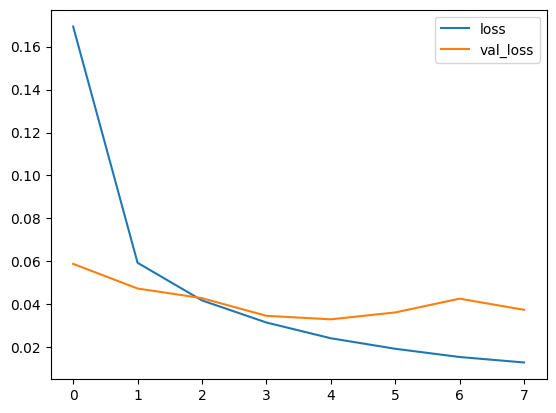

In [31]:
metrics[['loss', 'val_loss']].plot()

<AxesSubplot: >

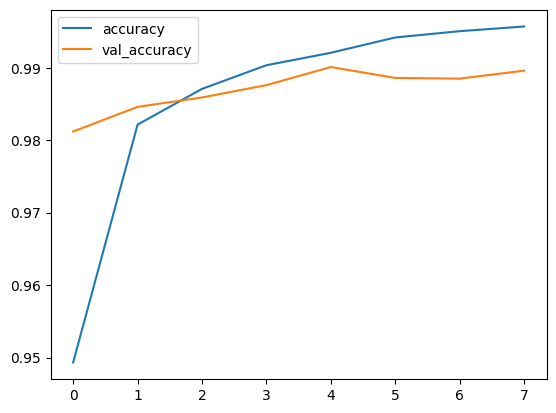

In [32]:
metrics[['accuracy', 'val_accuracy']].plot()

In [33]:
model.evaluate(x_test, y_test_cat)

313/313 [==============================] - 1s 2ms/step - loss: 0.0374 - accuracy: 0.9896


[0.03742336854338646, 0.9896000027656555]

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

In [35]:
y_pred = np.argmax(model.predict(x_test), axis=1)

313/313 [==============================] - 1s 1ms/step


In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.97      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.97      0.98       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [37]:
cm = confusion_matrix(y_test, y_pred)

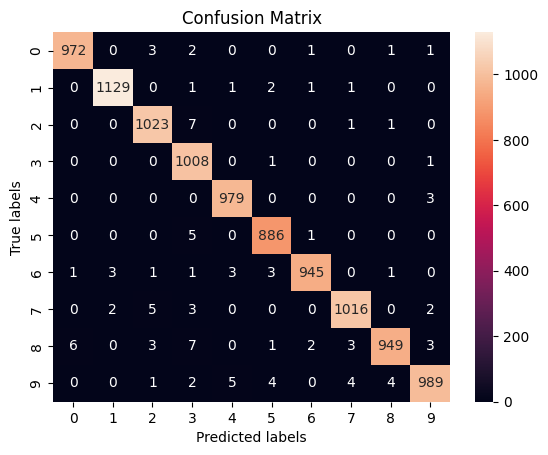

In [38]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [39]:
print(f'tensorboard --logdir {log_directory}')

tensorboard --logdir cnn_logs/fit/20230202-111730


In [ ]:
for layer in model.layers:
 # check for convolutional layer
    if 'conv' not in layer.name:
        continue
# get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d (4, 4, 1, 32)


In [ ]:
print(np.abs(filters[:,:,:,0]))

[[[0.17615838]
  [0.22437358]
  [0.21966672]
  [0.07523057]]

 [[0.11439515]
  [0.18703476]
  [0.13228911]
  [0.22764257]]

 [[0.05812916]
  [0.14184833]
  [0.12904102]
  [0.2472254 ]]

 [[0.19682609]
  [0.11767133]
  [0.27255565]
  [0.13672285]]]


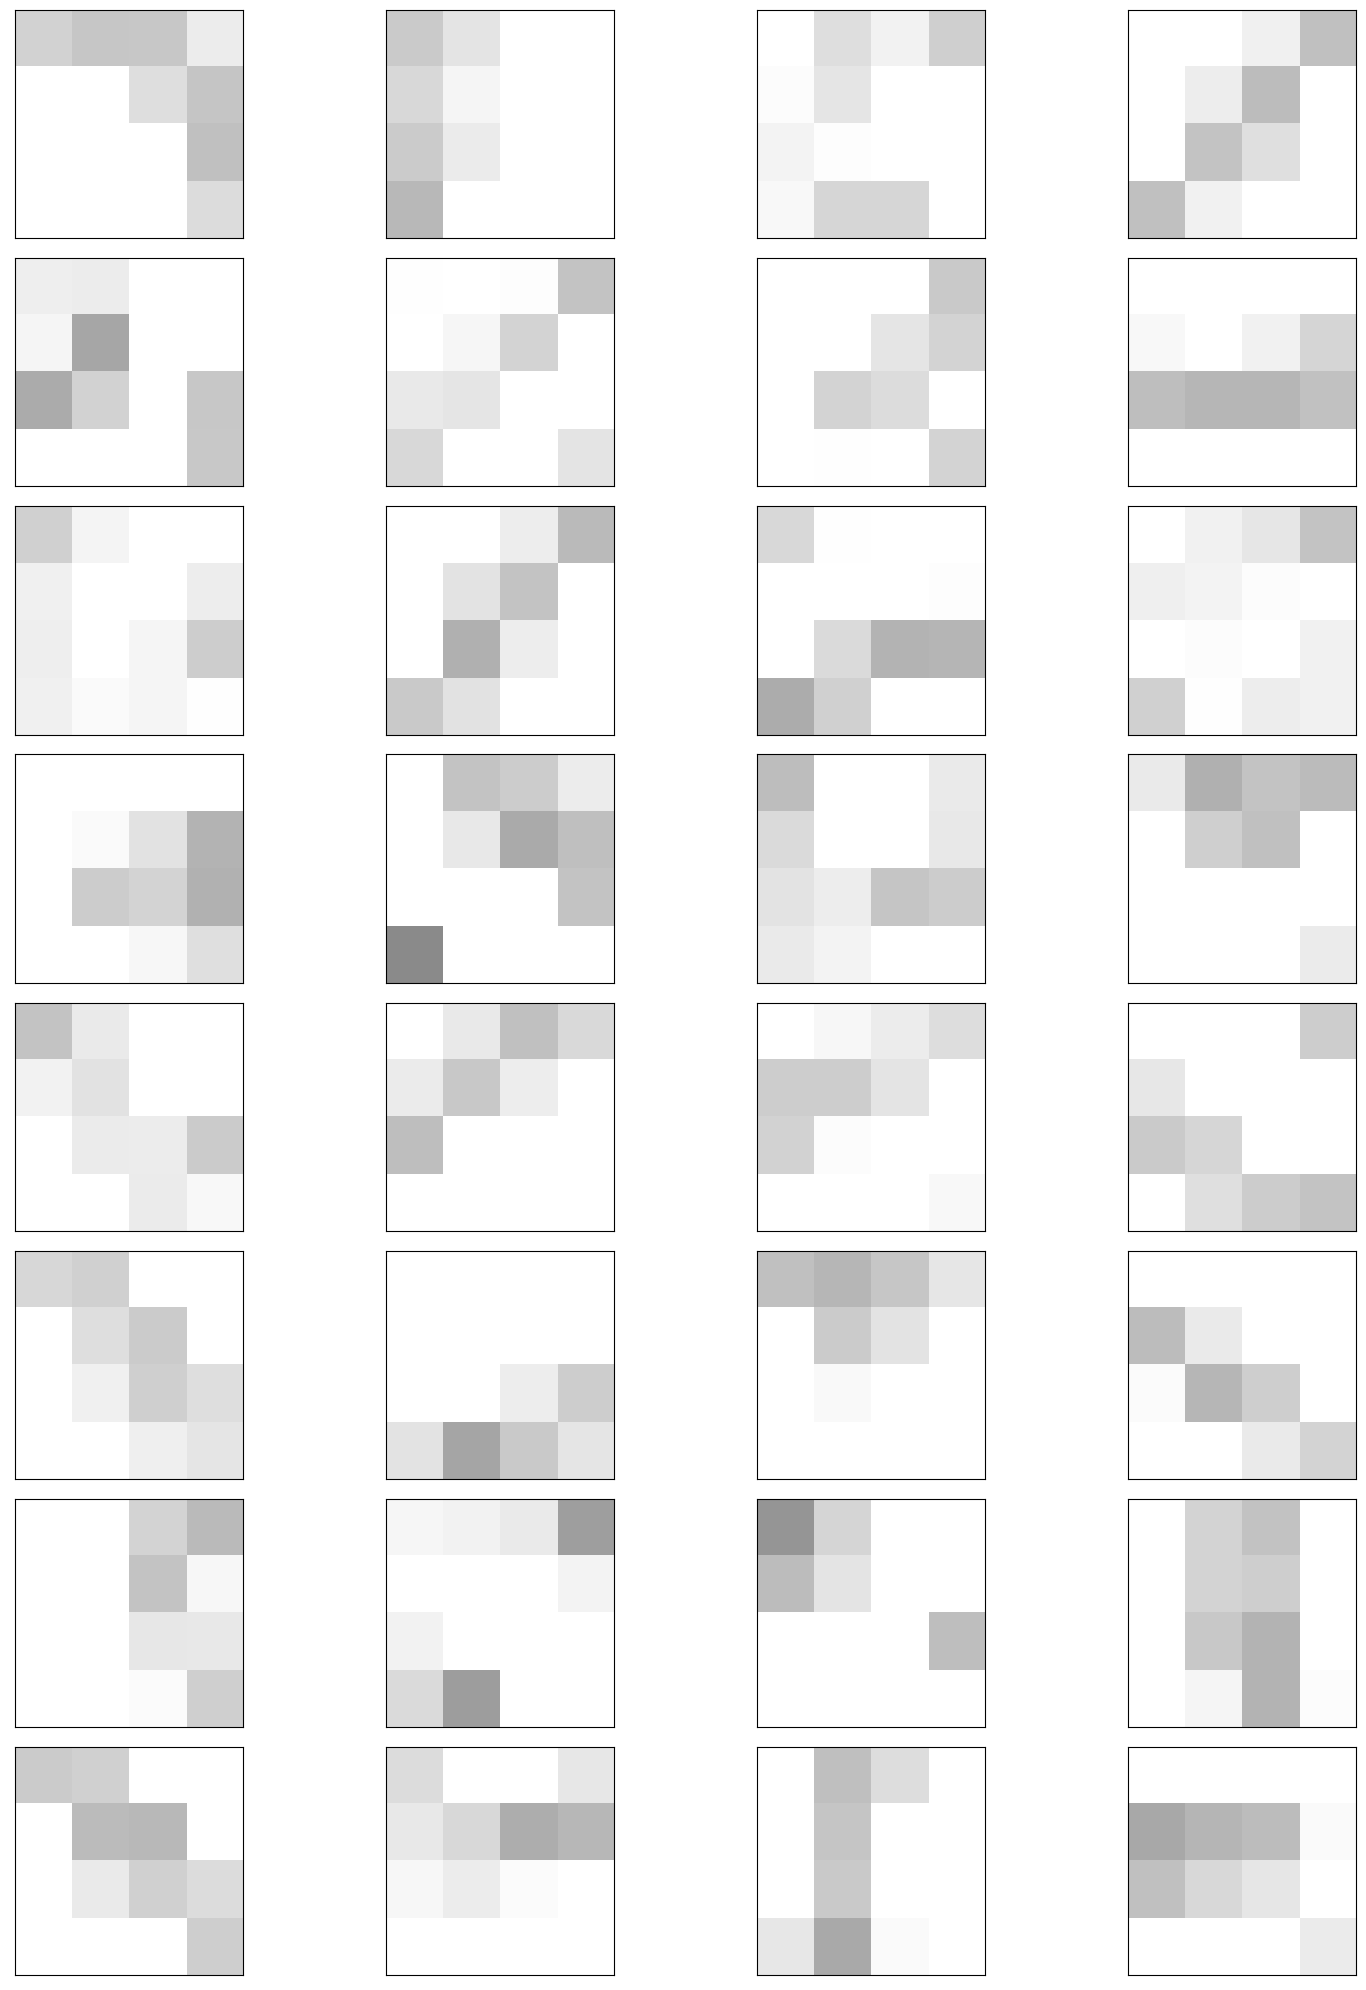

In [43]:
# plot first few filters

n_filters, ix = 32, 1
ncols = 4

fig, axs = plt.subplots(figsize=(16,20), nrows=(n_filters + (ncols-1))//ncols, ncols=ncols)
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
        # plot filter channel in grayscale
        #sns.heatmap(f[:, :, j], ax=axs[i//ncols, i%ncols], cmap='binary', vmin=-1, vmax=1)
        axs[i//ncols, i%ncols].set_xticks([])
        axs[i//ncols, i%ncols].set_yticks([])
        axs[i//ncols, i%ncols].imshow(f[:, :, j], cmap='binary', vmin=0, vmax=1)
        ix += 1
# show the figure
plt.tight_layout()
plt.show()

In [44]:
samples = {key: None for key in list(set(y_train))}
done = False
idx = 0

while not done:
    if not samples[y_train[idx]]:
        samples[y_train[idx]] = idx
        test_done = True
        for k in samples.keys():
            if not samples[k]:
                test_done = False
                break
        if test_done:
            done = True
    idx += 1

print(samples)
            

{0: 1, 1: 3, 2: 5, 3: 7, 4: 2, 5: 11, 6: 13, 7: 15, 8: 17, 9: 4}


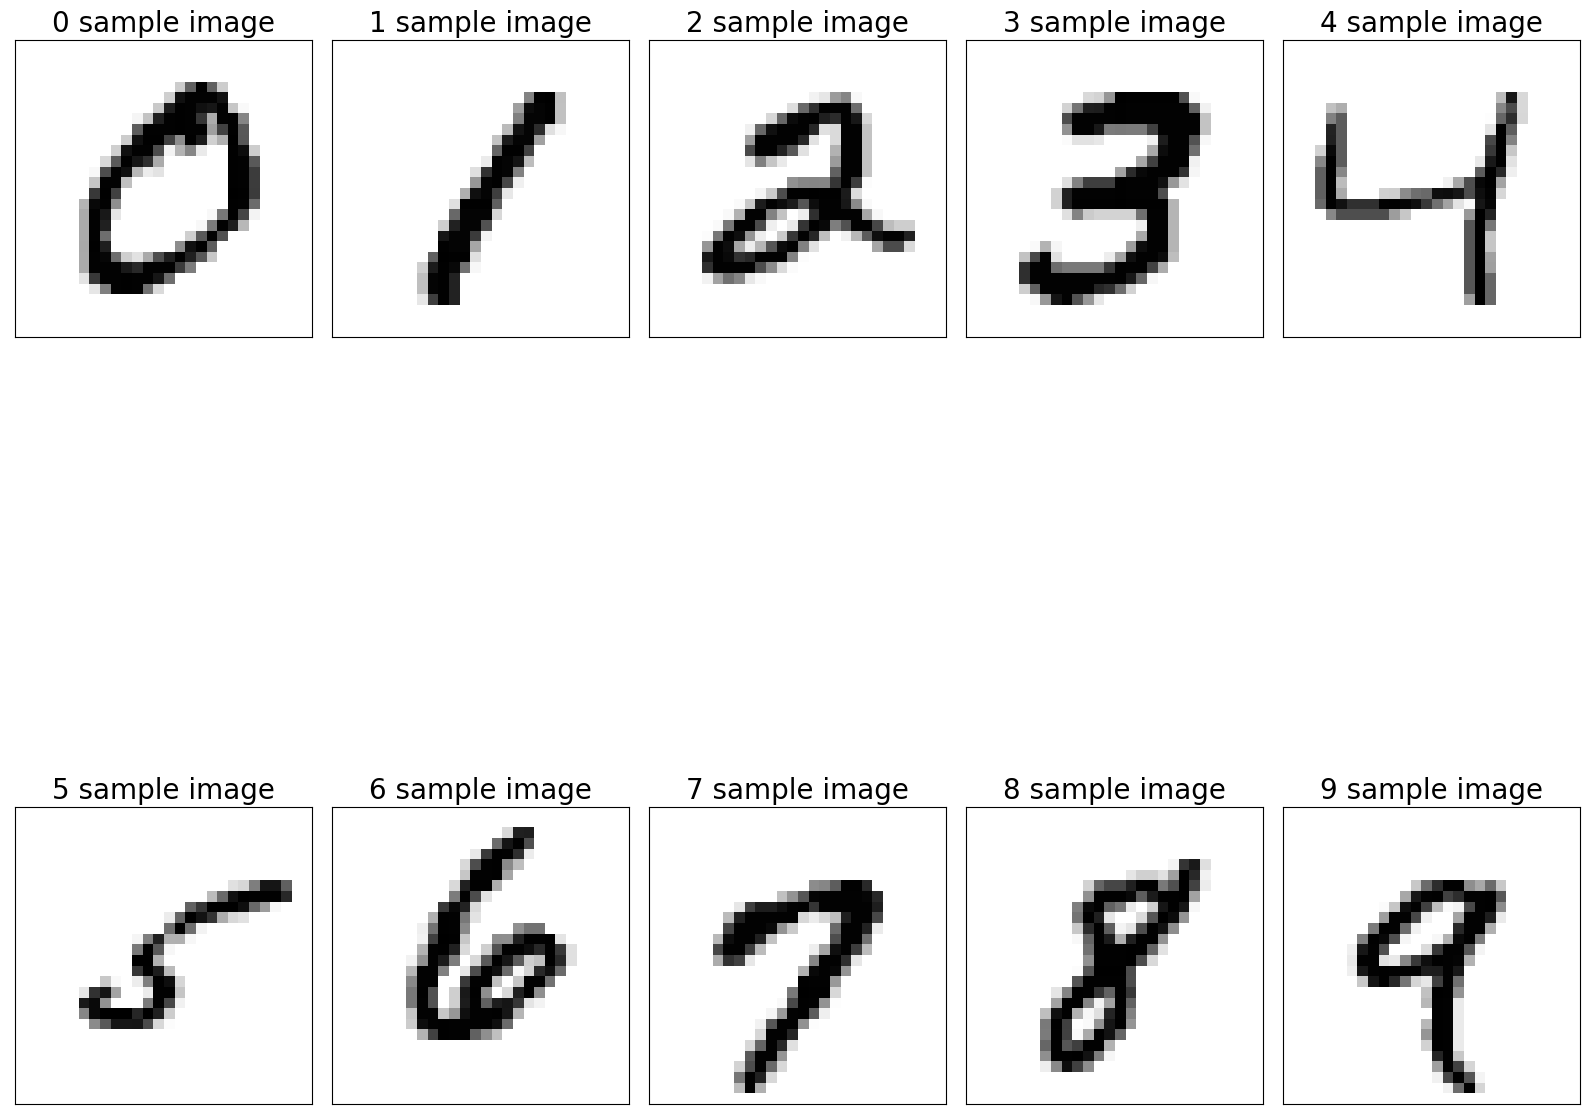

In [45]:
# plot first few filters

ncols = 5

fig, axs = plt.subplots(figsize=(16,20), nrows=(len(samples.keys()) + (ncols-1))//ncols, ncols=ncols)
for i in samples.keys():
    axs[i//ncols, i%ncols].set_xticks([])
    axs[i//ncols, i%ncols].set_yticks([])
    axs[i//ncols, i%ncols].set_title(f'{i} sample image', fontsize=20)
        # plot filter channel in grayscale
    axs[i//ncols, i%ncols].imshow(x_train[samples[i]], cmap='binary', vmin=0, vmax=1)
    ix += 1
# show the figure
plt.tight_layout()
plt.show()

In [46]:
from tensorflow.keras.models import Model

fmap_model = Model(inputs=model.inputs, outputs=model.layers[0].output)
fmap_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 25, 25, 32)        544       
                                                                 
Total params: 544
Trainable params: 544
Non-trainable params: 0
_________________________________________________________________


1/1 [==============================] - 0s 38ms/step


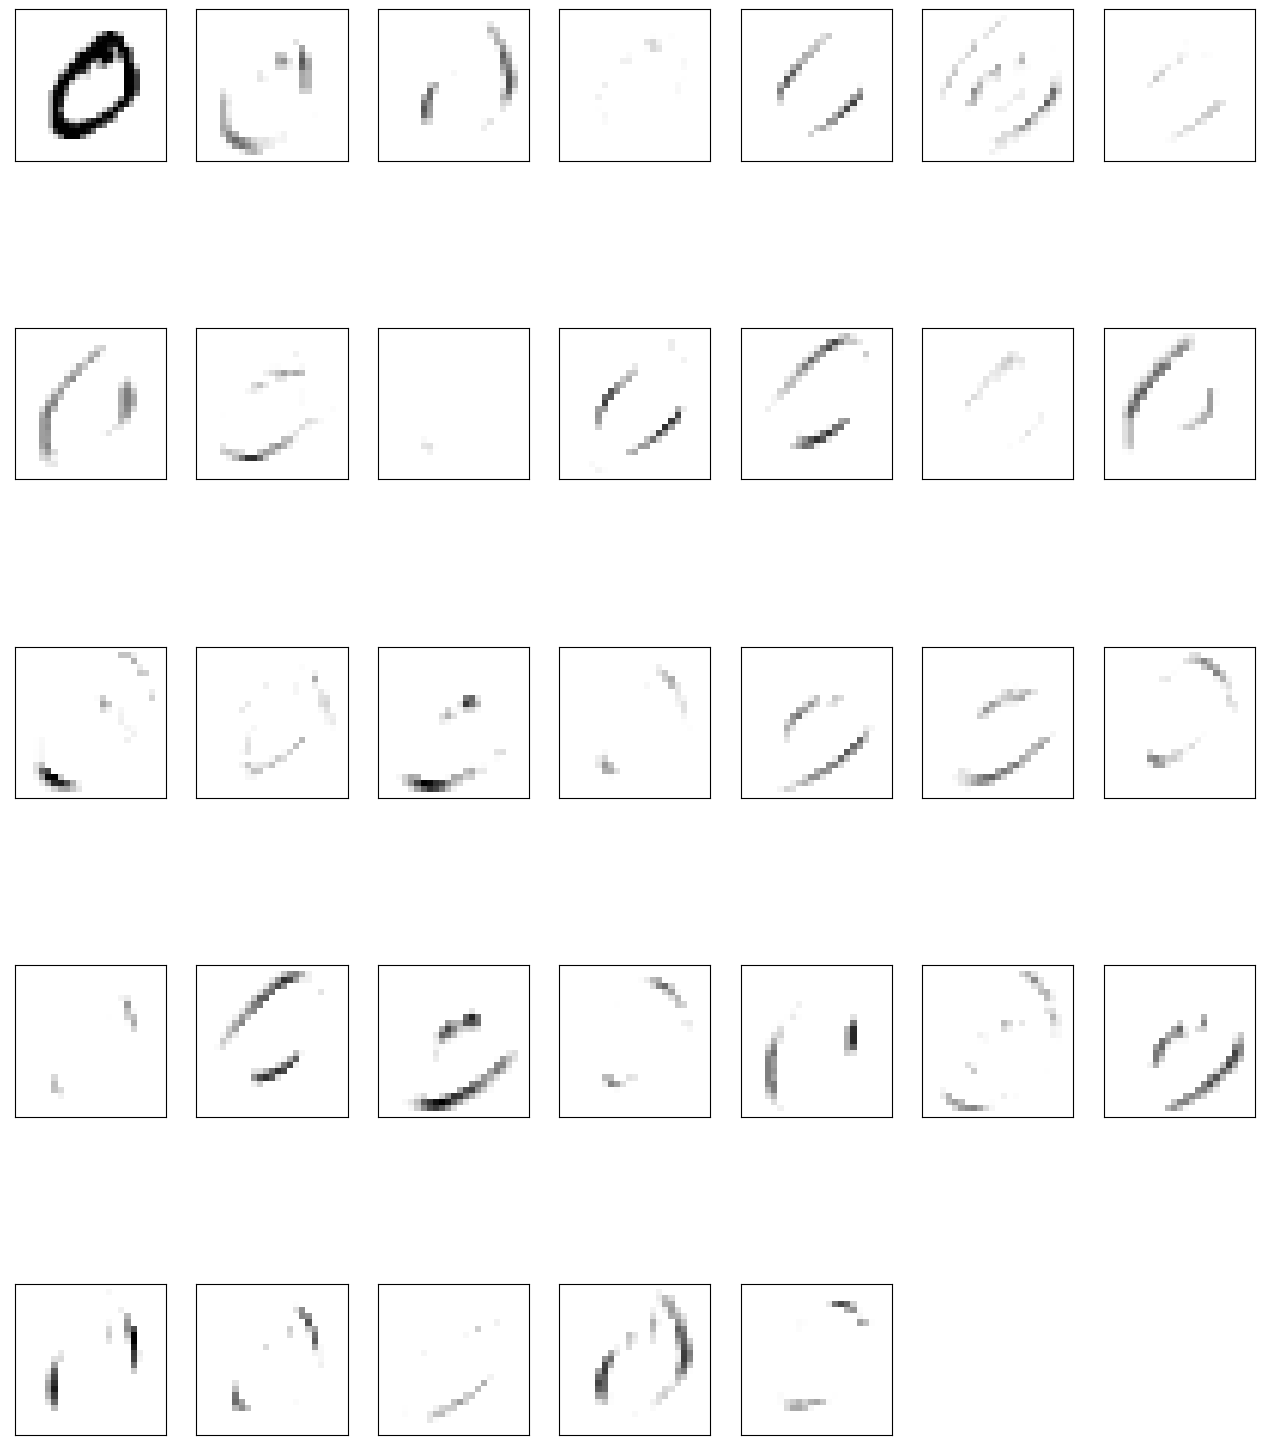

In [47]:
val = 0
img = x_train[samples[val]].reshape(1,28,28,1)

feature_maps = fmap_model.predict(img)
# plot original imapge and all 32 maps in a 3x11 square
nrows = 5
ncols = 7

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(28,28), cmap='binary')

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary', vmin=0, vmax=1)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 17ms/step


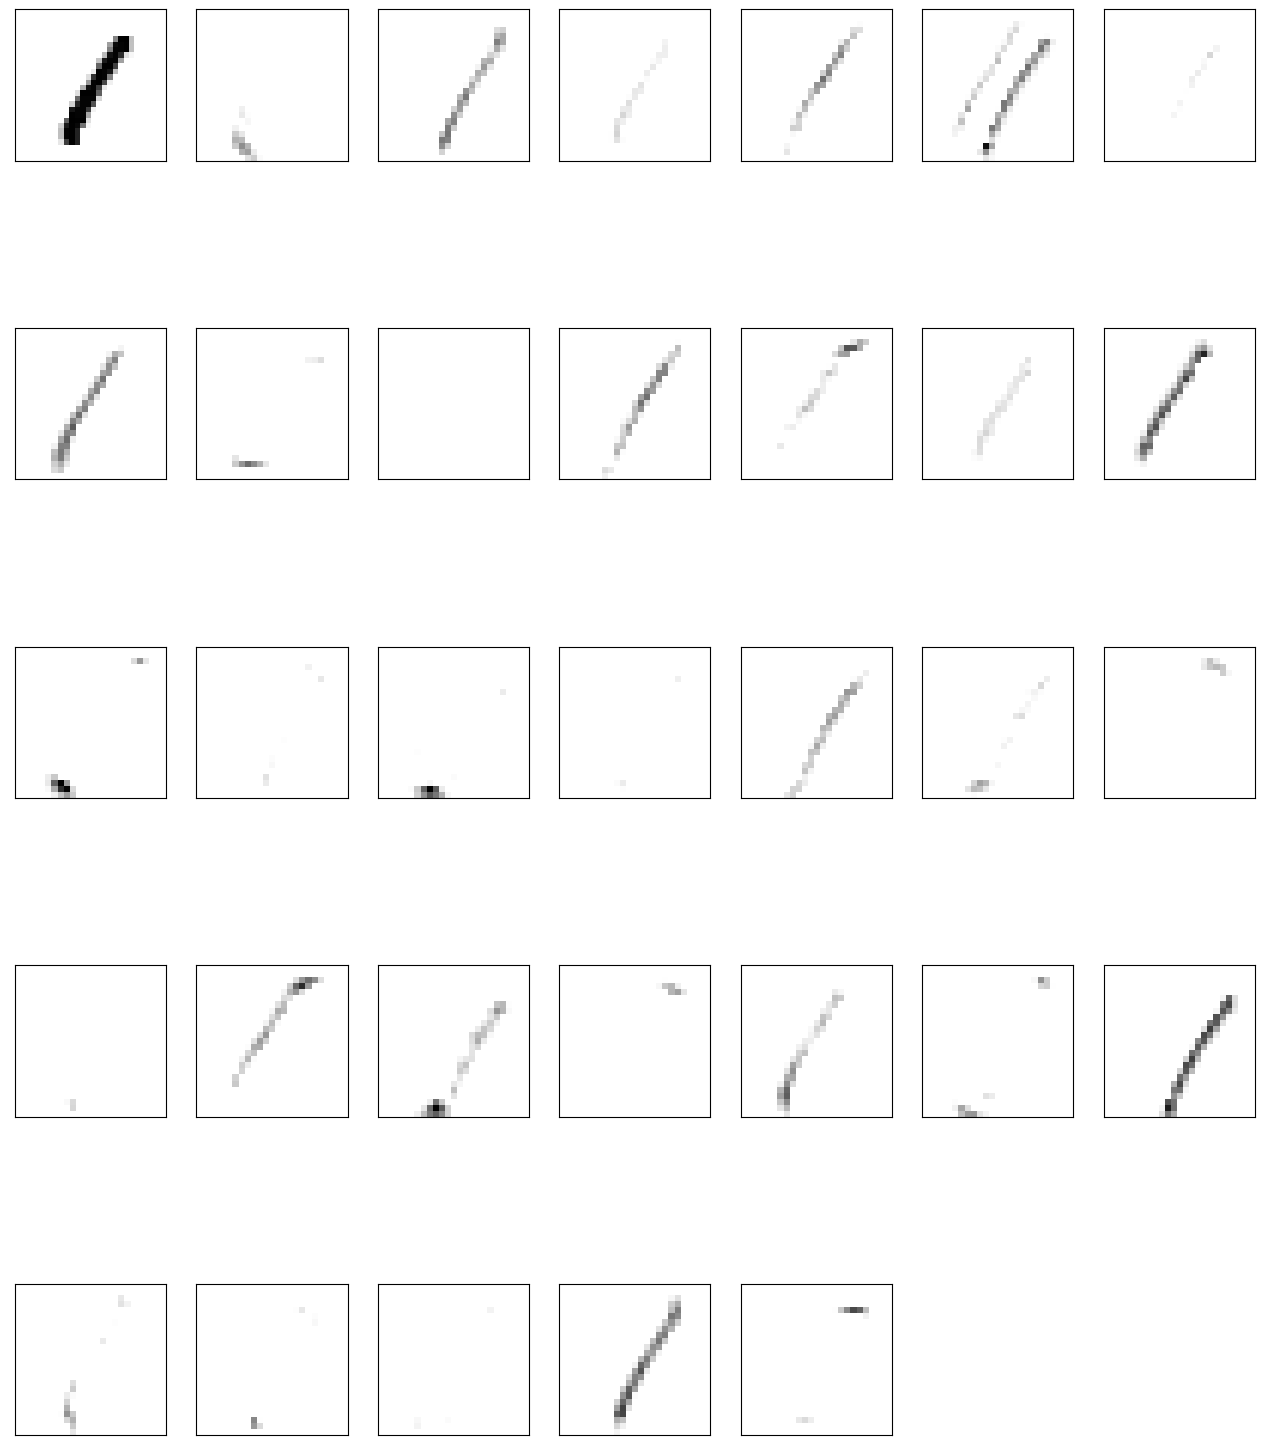

In [48]:
val = 1
img = x_train[samples[val]].reshape(1,28,28,1)

feature_maps = fmap_model.predict(img)
# plot original imapge and all 8 maps in a 3x3 square
nrows = 5
ncols = 7

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(28,28), cmap='binary')

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary', vmin=0, vmax=1)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 13ms/step


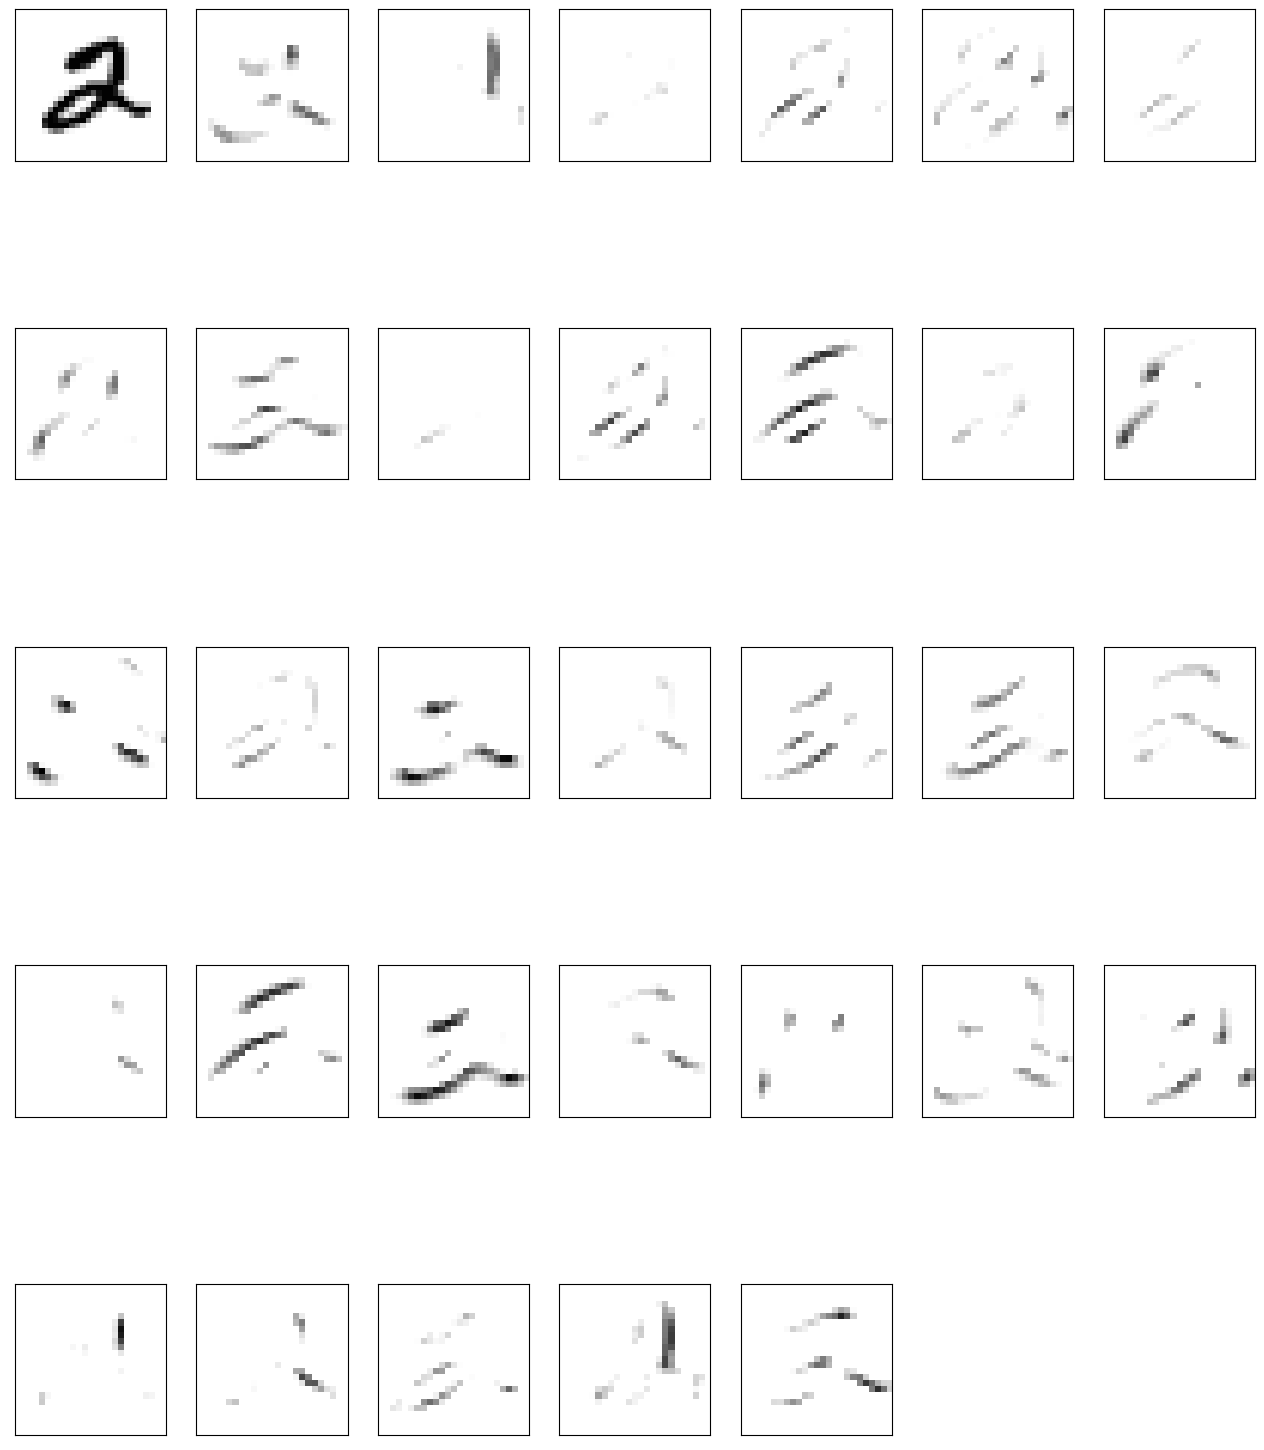

In [49]:
val = 2
img = x_train[samples[val]].reshape(1,28,28,1)

feature_maps = fmap_model.predict(img)
# plot original imapge and all 8 maps in a 3x3 square
nrows = 5
ncols = 7

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(28,28), cmap='binary')

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary', vmin=0, vmax=1)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 15ms/step


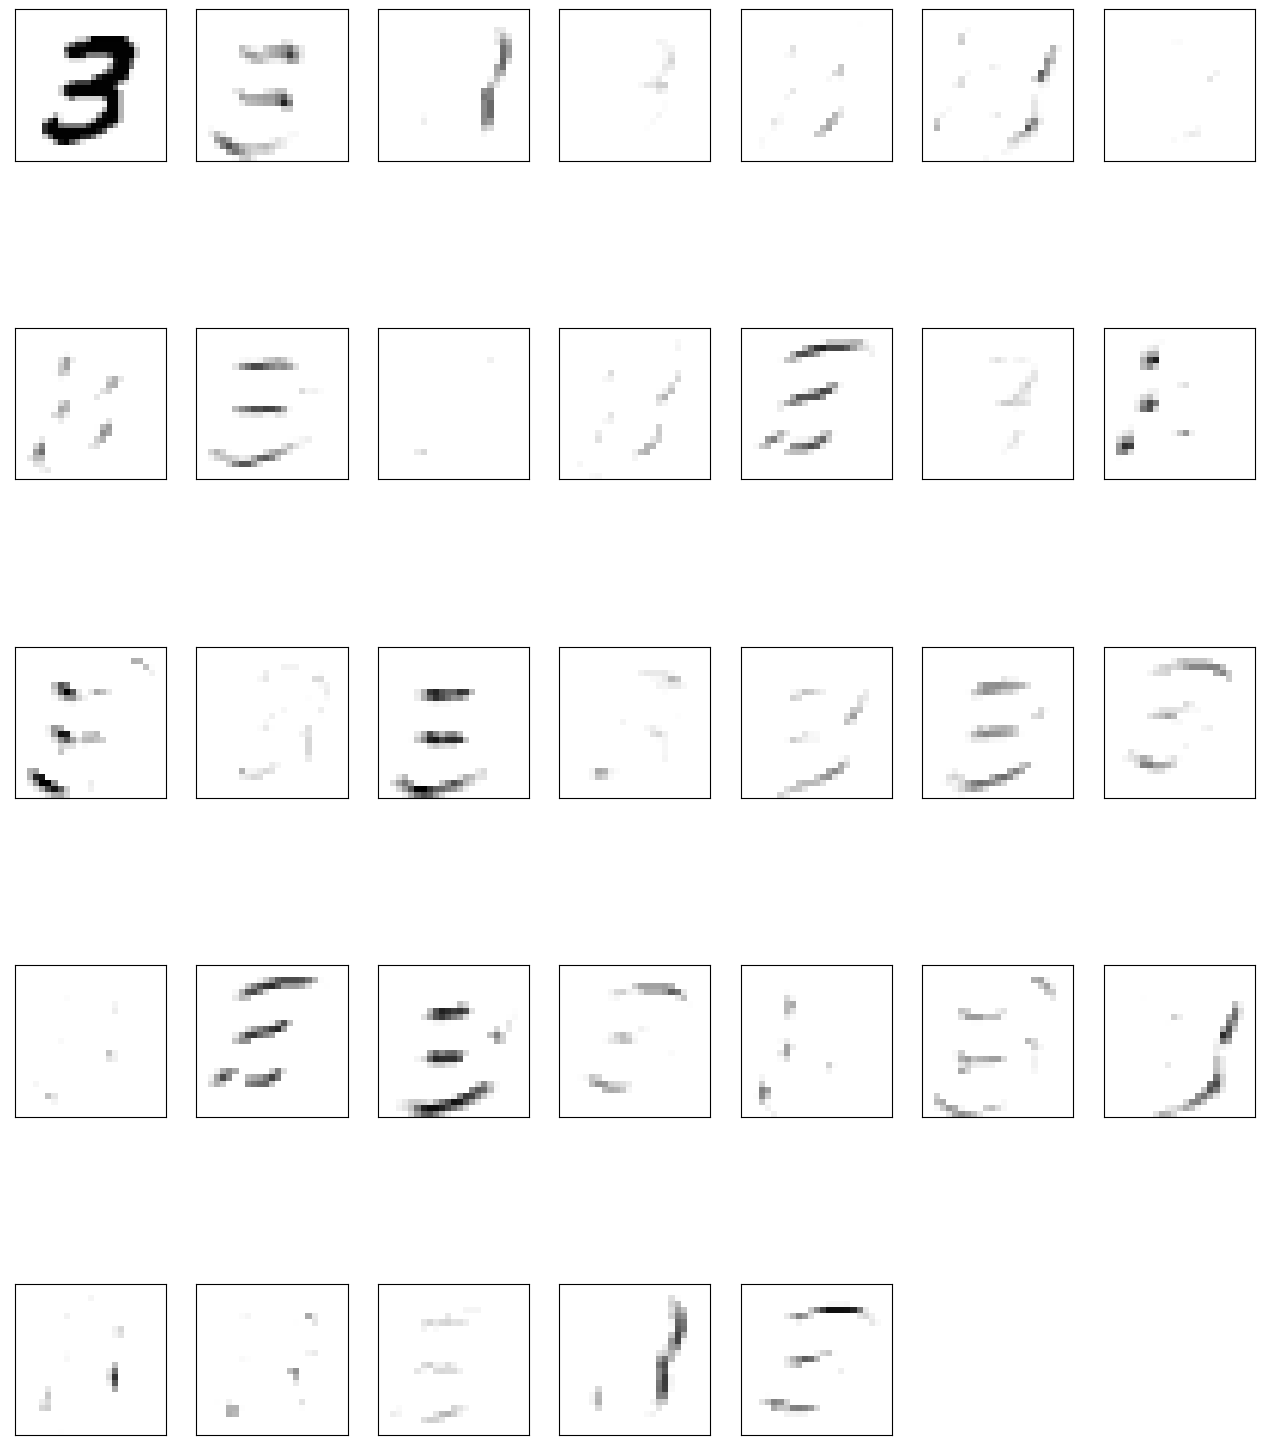

In [50]:
val = 3
img = x_train[samples[val]].reshape(1,28,28,1)

feature_maps = fmap_model.predict(img)
# plot original imapge and all 8 maps in a 3x3 square
nrows = 5
ncols = 7

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(28,28), cmap='binary')

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary', vmin=0, vmax=1)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 15ms/step


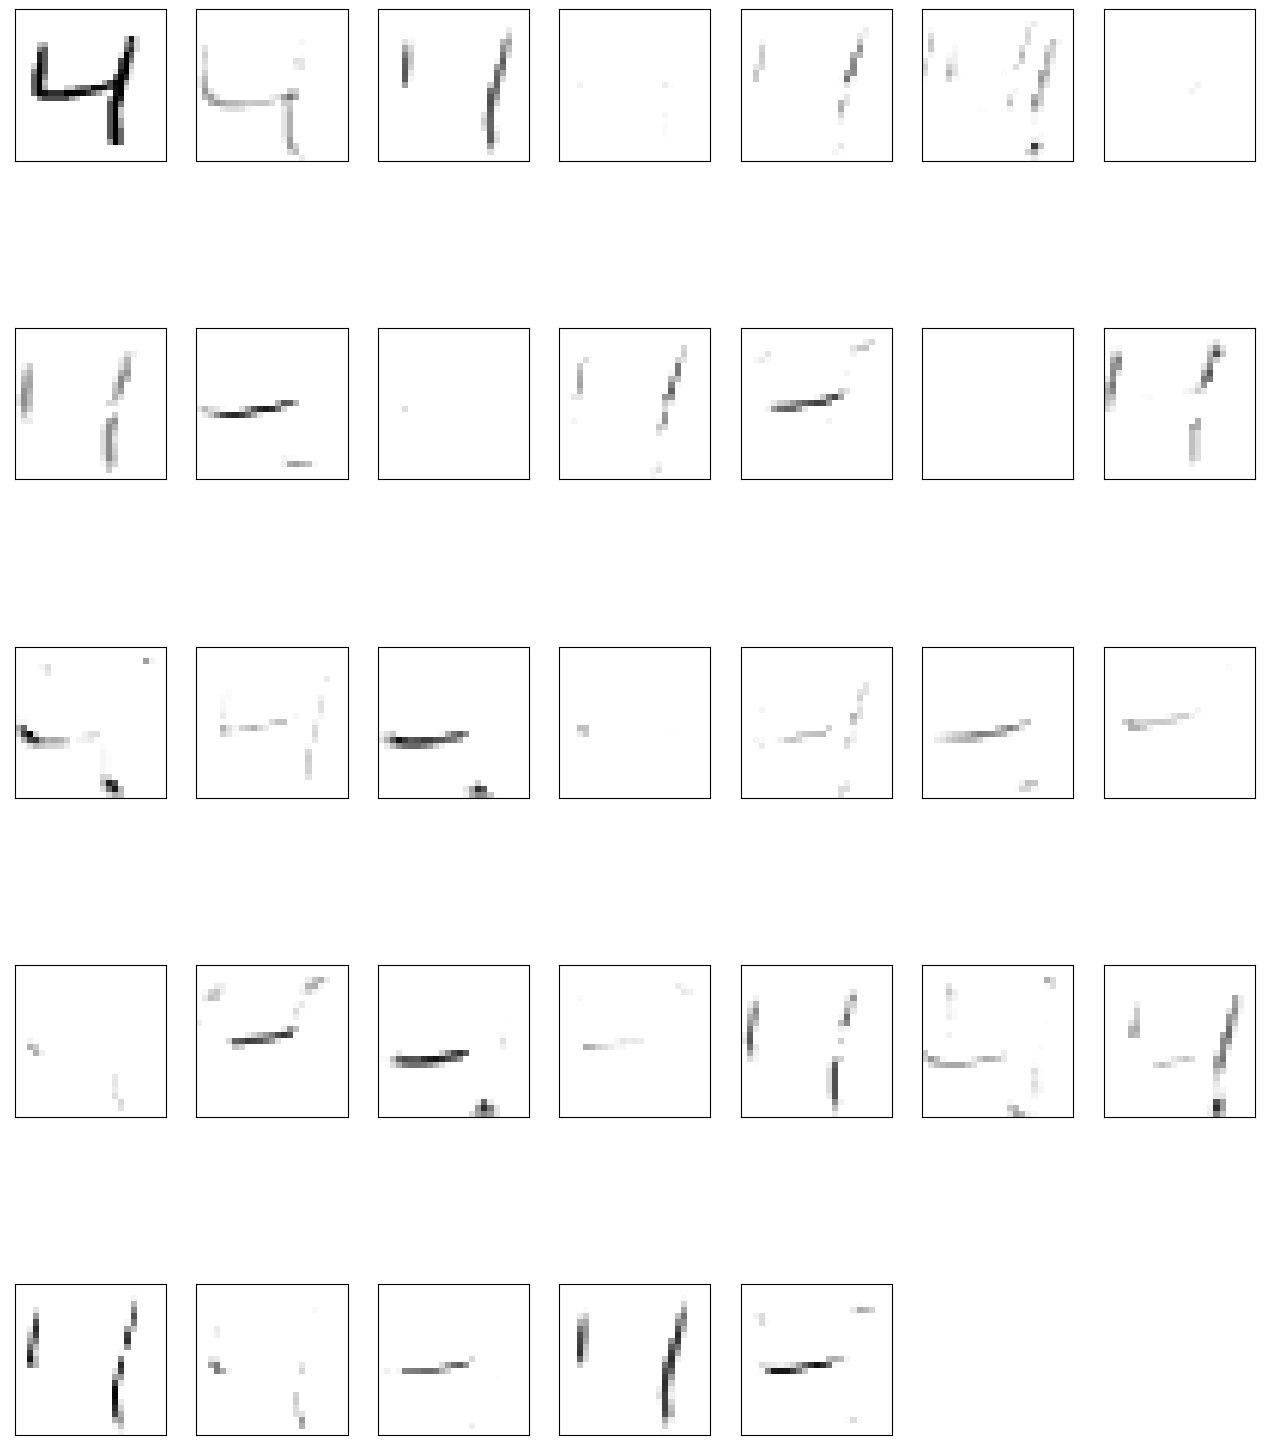

In [51]:
val = 4
img = x_train[samples[val]].reshape(1,28,28,1)

feature_maps = fmap_model.predict(img)
# plot original imapge and all 8 maps in a 3x3 square
nrows = 5
ncols = 7

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(28,28), cmap='binary')

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary', vmin=0, vmax=1)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 17ms/step


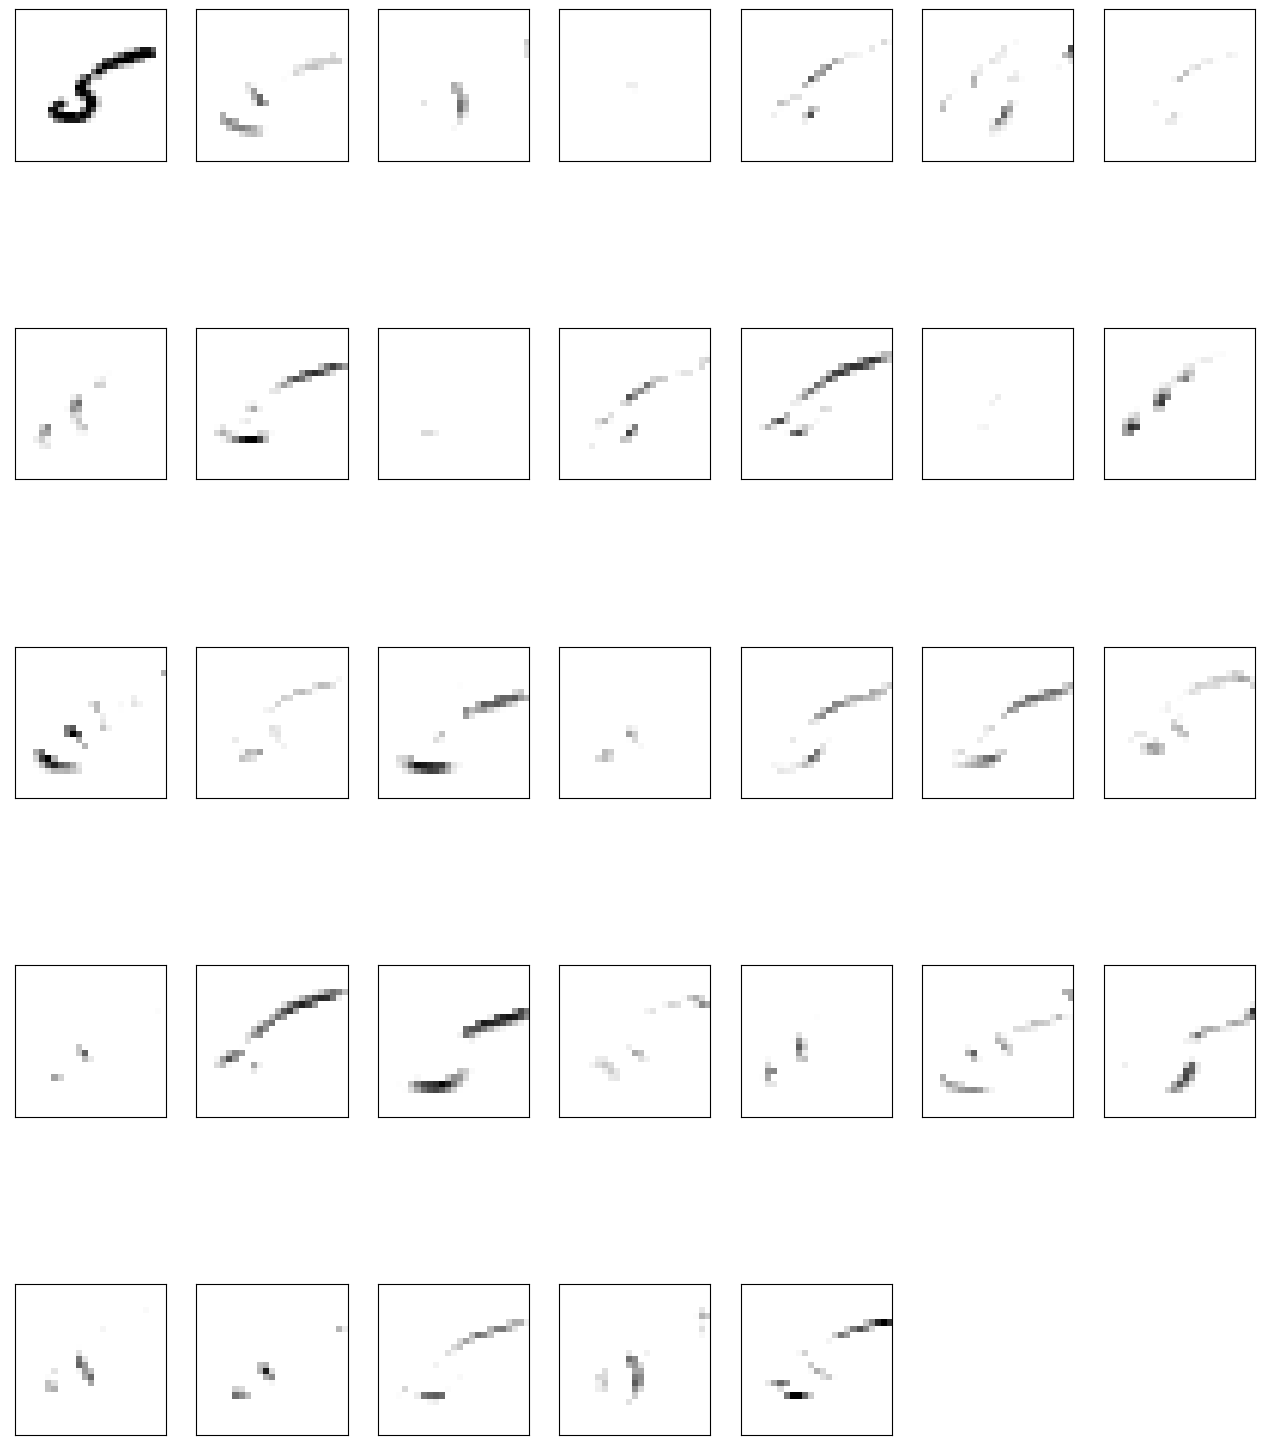

In [52]:
val = 5
img = x_train[samples[val]].reshape(1,28,28,1)

feature_maps = fmap_model.predict(img)
# plot original imapge and all 8 maps in a 3x3 square
nrows = 5
ncols = 7

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(28,28), cmap='binary')

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary', vmin=0, vmax=1)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 16ms/step


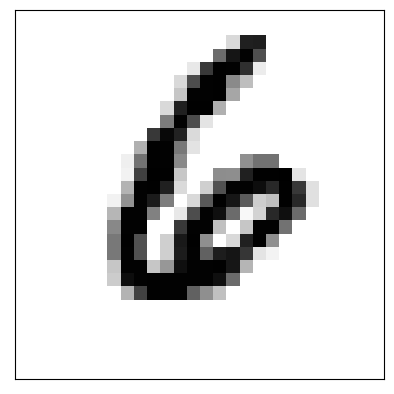

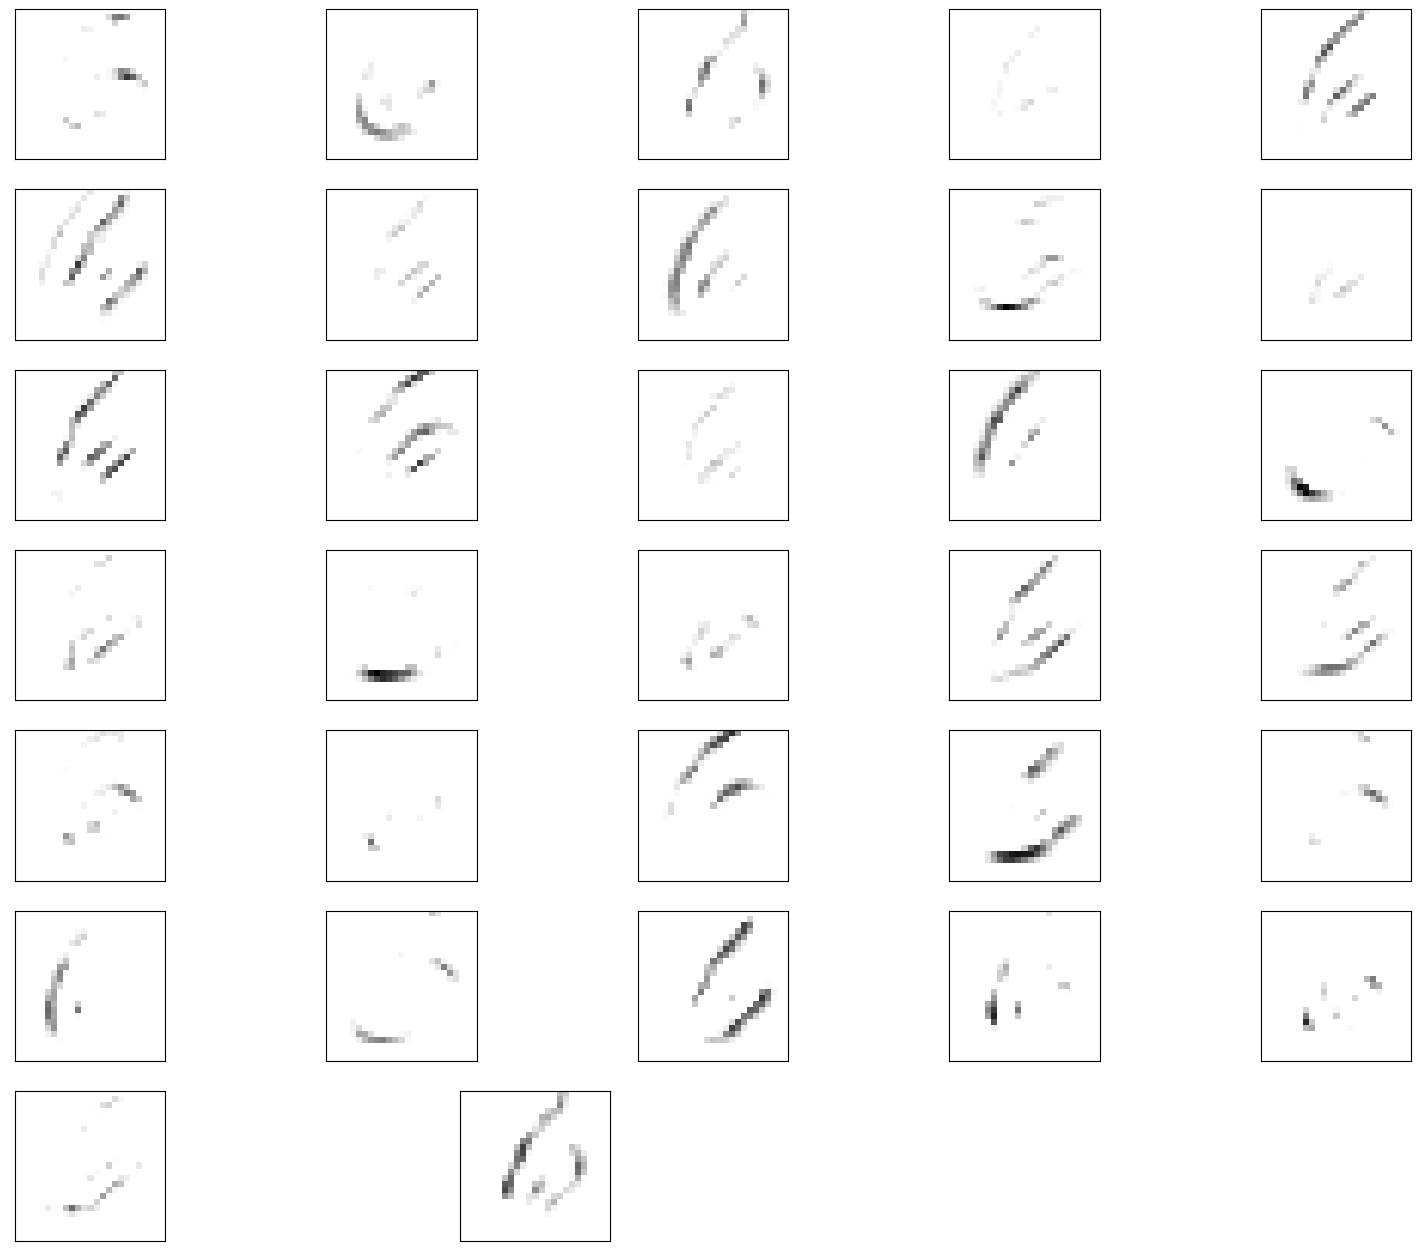

In [53]:
val = 6
img = x_train[samples[val]].reshape(1,28,28,1)

feature_maps = fmap_model.predict(img)
# plot original imapge and all 8 maps in a 3x3 square
nrows = 7
ncols = 5
num_feature_maps = len(feature_maps[0][0][0])
buffer = 10 #nrows*ncols - num_feature_maps

plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(28,28), cmap='binary')
plt.show()

fig = plt.figure(figsize=(20, 16))
gs = gridspec.GridSpec(nrows, nrows*ncols)

ix = 0
for _ in range(num_feature_maps):
    if ix <= (nrows-1)*ncols:
        # specify subplot and turn of axis
        #ax = axs[ix//ncols, ix%ncols]
        ax = plt.subplot(gs[ix//ncols, nrows * (ix % ncols): nrows * (ix % ncols) + (nrows-1)])
    else:
        ax = plt.subplot(
            gs[
                -1, 
                nrows * (ix % ncols) - num_feature_maps:  nrows * (ix % ncols) - num_feature_maps + (nrows-1)
            ]
        )
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    ax.imshow(feature_maps[0,:,:,ix-1], cmap='binary', vmin=0, vmax=1)
    ix += 1

#for i in range(len(feature_maps[0][0][0]), ncols*nrows):
    #axs.flat[i].remove()
    
plt.show()

1/1 [==============================] - 0s 17ms/step


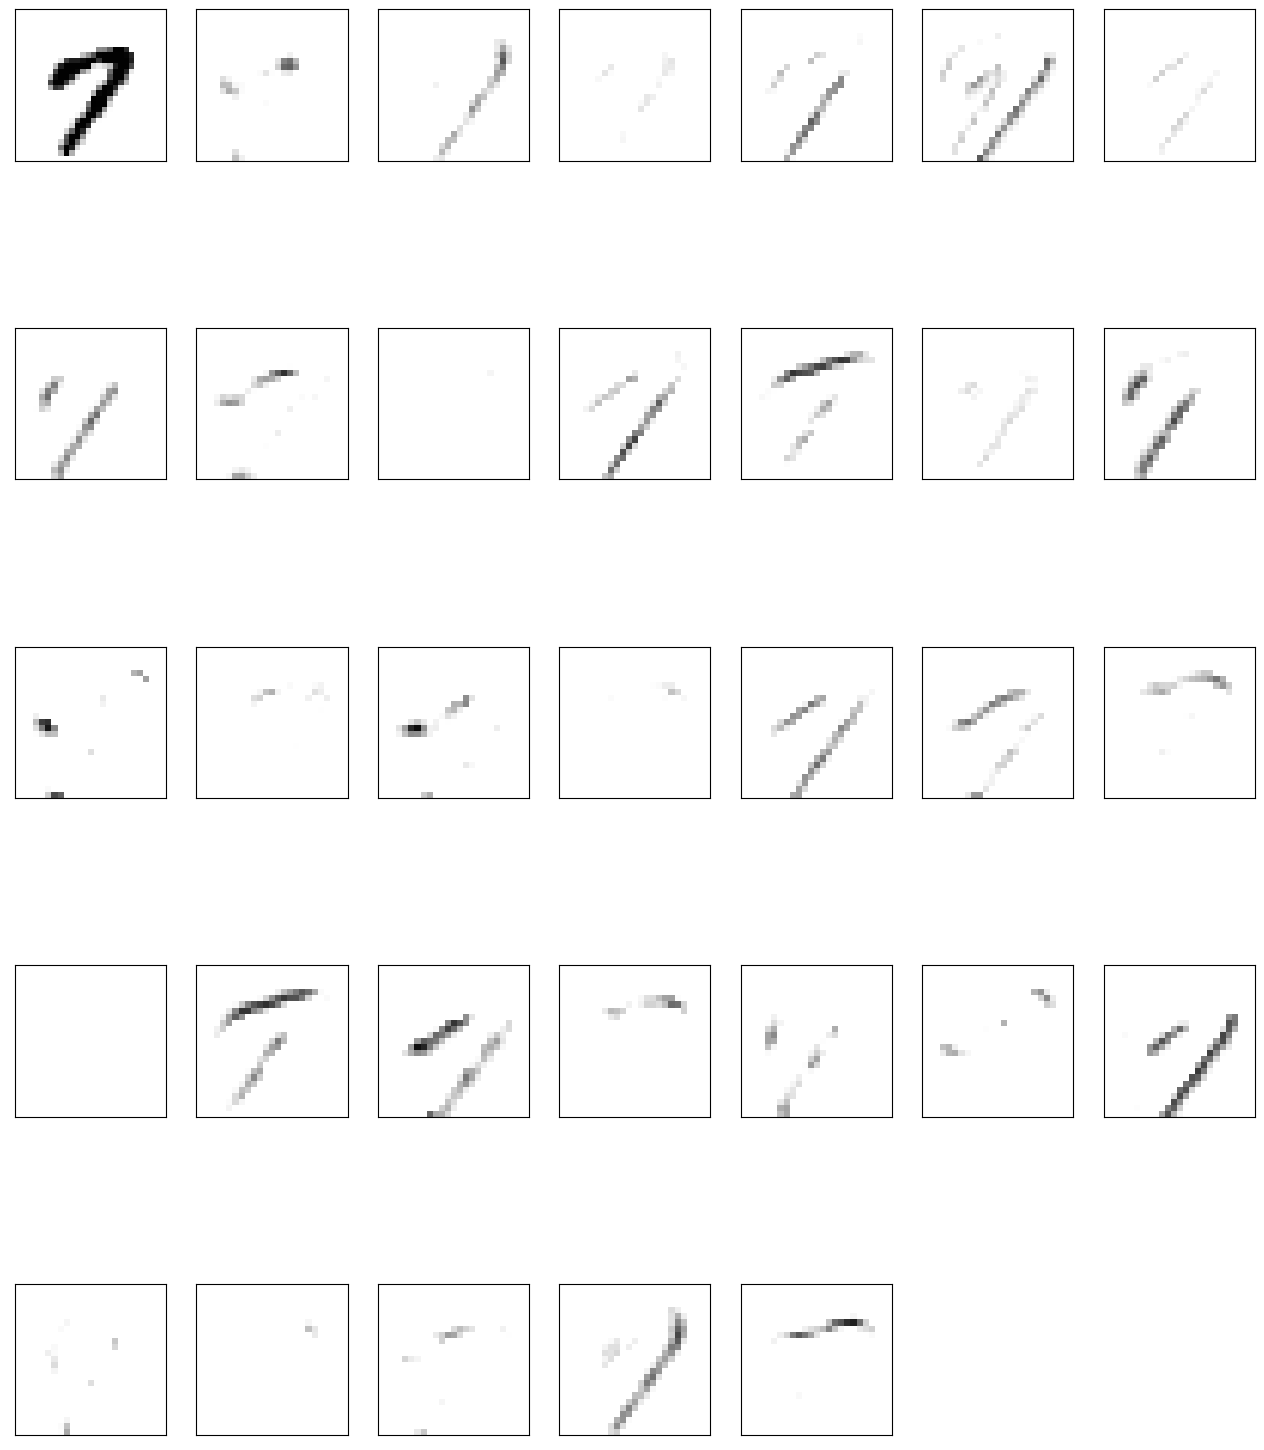

In [54]:
val = 7
img = x_train[samples[val]].reshape(1,28,28,1)

feature_maps = fmap_model.predict(img)
# plot original imapge and all 8 maps in a 3x3 square
nrows = 5
ncols = 7

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(28,28), cmap='binary')

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary', vmin=0, vmax=1)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 15ms/step


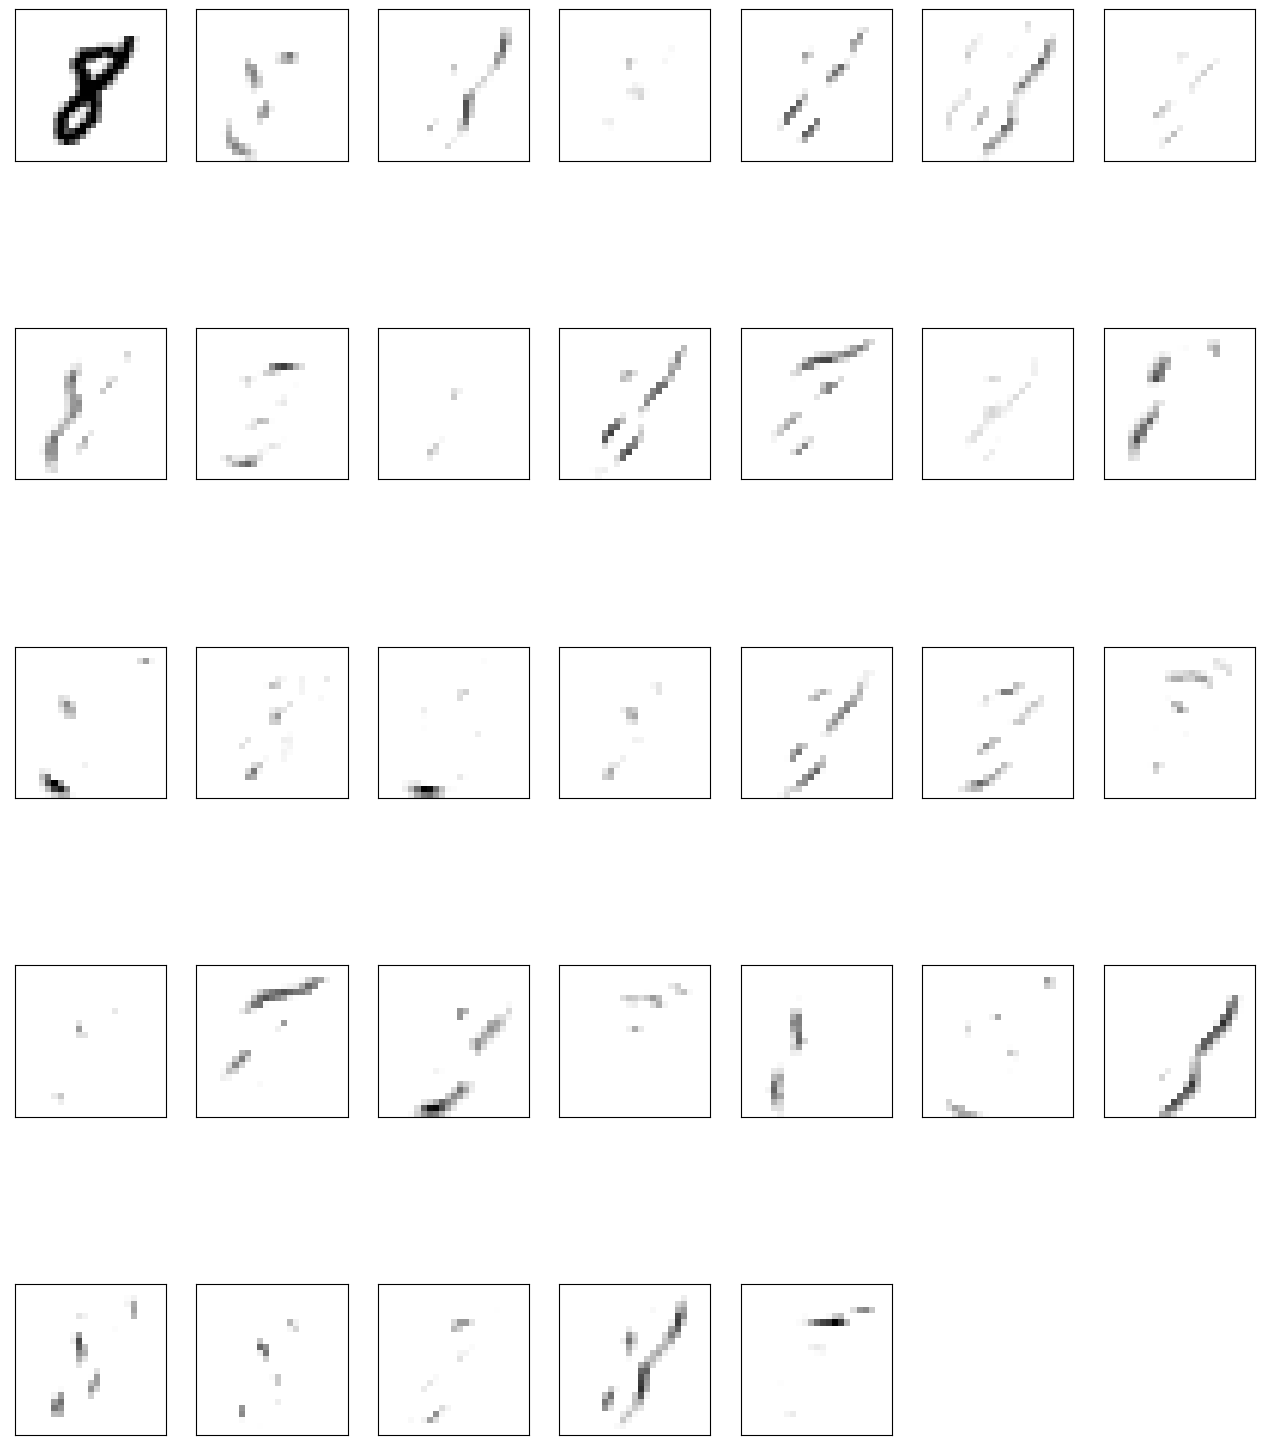

In [55]:
val = 8
img = x_train[samples[val]].reshape(1,28,28,1)

feature_maps = fmap_model.predict(img)
# plot original imapge and all 8 maps in a 3x3 square
nrows = 5
ncols = 7

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(28,28), cmap='binary')

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary', vmin=0, vmax=1)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()

1/1 [==============================] - 0s 15ms/step


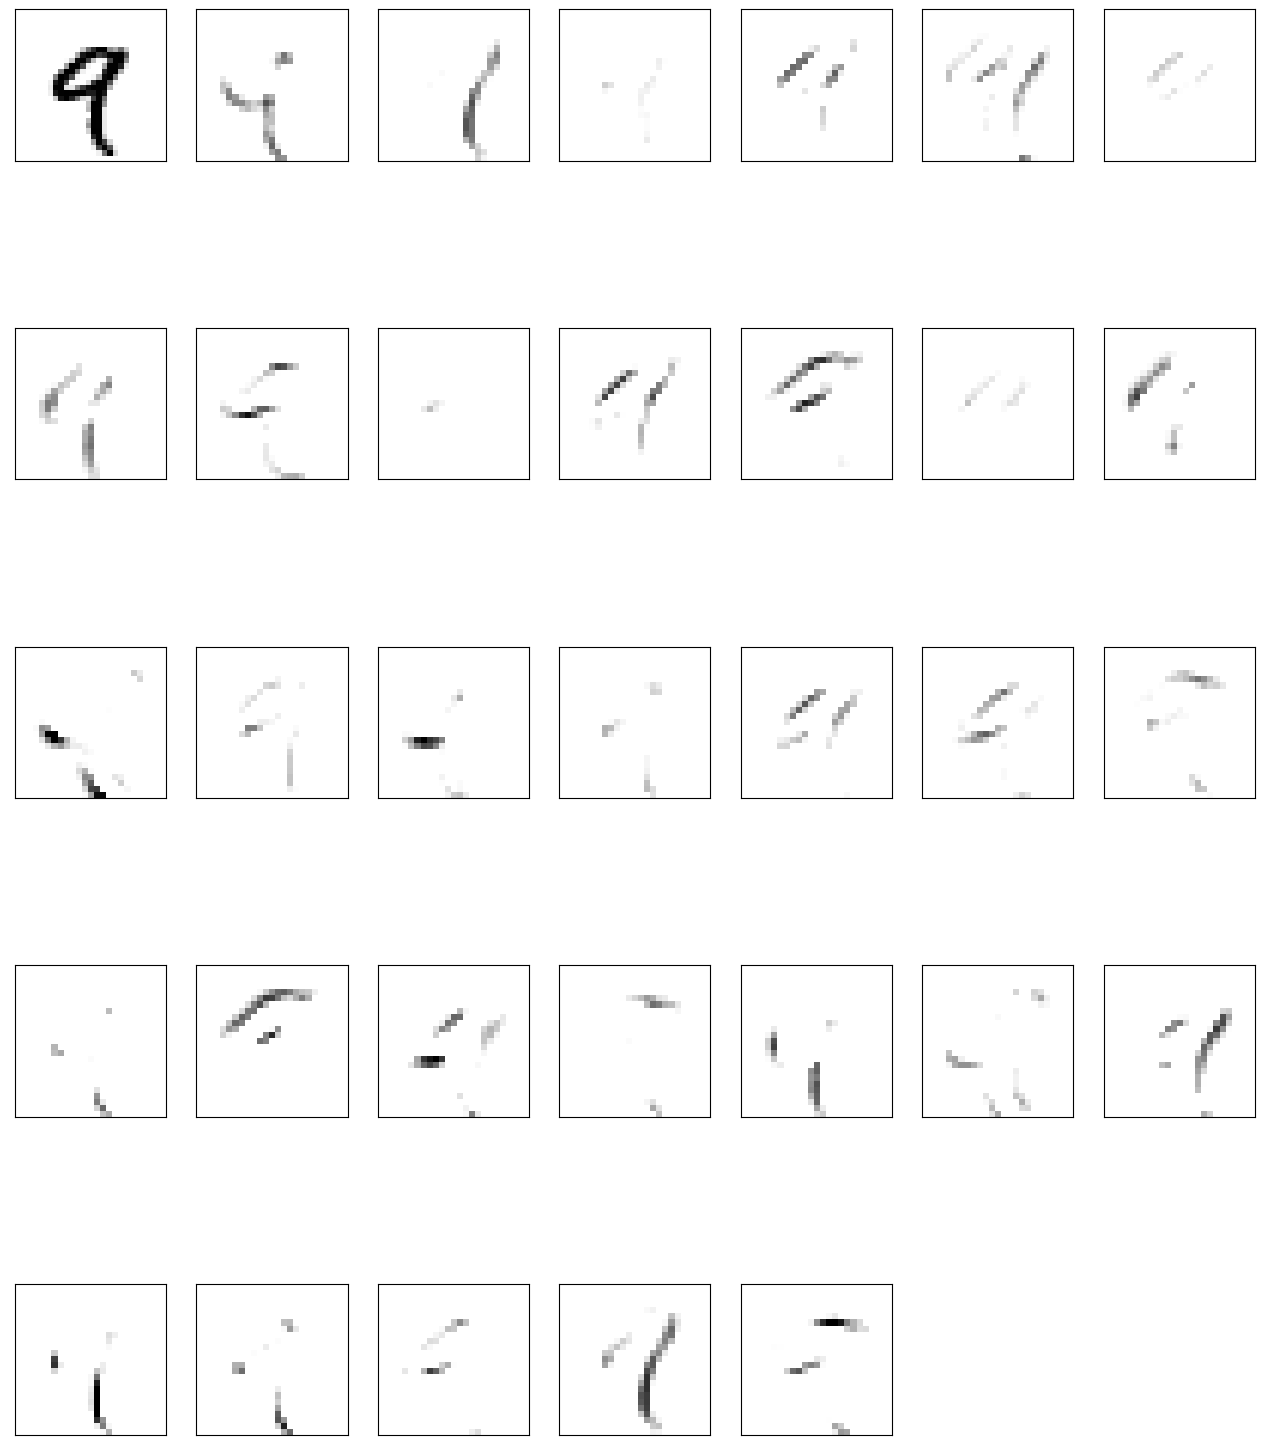

In [56]:
val = 9
img = x_train[samples[val]].reshape(1,28,28,1)

feature_maps = fmap_model.predict(img)
# plot original imapge and all 8 maps in a 3x3 square
nrows = 5
ncols = 7

fig, axs = plt.subplots(figsize=(16,20), nrows=nrows, ncols=ncols)

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].imshow(img.reshape(28,28), cmap='binary')

ix = 1
for _ in range(len(feature_maps[0][0][0])):
    # specify subplot and turn of axis
    axs[ix//ncols, ix%ncols].set_xticks([])
    axs[ix//ncols, ix%ncols].set_yticks([])
    # plot filter channel in grayscale
    axs[ix//ncols, ix%ncols].imshow(feature_maps[0,:,:,ix-1], cmap='binary', vmin=0, vmax=1)
    ix += 1

for i in range(len(feature_maps[0][0][0])+1, ncols*nrows):
    axs.flat[i].set_visible(False)
    
plt.show()